In [1]:
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from copy import deepcopy

In [2]:
df_0 = pd.read_csv('contango_cost_180_20.csv', index_col=0, header=[0,1,2])
#df.columns.names = ['run_name', 'feature', 'pool']
df_0

2024-03-27_2023-09-29_[5]_3_3d_10d_0.05_1.0_0.0_1_1000000.0  \
                                                                              weights   
                                                                Ethereum_aave-v3_USDC   
2023-09-29 00:00:00+00:00                                           0.000000            
2023-09-30 00:00:00+00:00                                      253235.058505            
2023-10-01 00:00:00+00:00                                          43.741621            
2023-10-02 00:00:00+00:00                                          43.744903            
2023-10-03 00:00:00+00:00                                      307414.543091            
...                                                                      ...            
2024-03-23 00:00:00+00:00                                           9.911342            
2024-03-24 00:00:00+00:00                                           9.913793            
2024-03-25 00:00:00+00:00                                           9.915988            
2024-03-26 00:00:00+00:00                                           9.920219            
2024-03-27 00:00:00+00:00                                           9.922375            

                                                               \
                                                                
                          Ethereum_compound-v3_USDC_USDC-pool   
2023-09-29 00:00:00+00:00                            0.000000   
2023-09-30 00:00:00+00:00                            0.000000   
2023-10-01 00:00:00+00:00                            0.000000   
2023-10-02 00:00:00+00:00                            0.000000   
2023-10-03 00:00:00+00:00                            0.000000   
...                                                       ...   
2024-03-23 00:00:00+00:00                            8.285394   
2024-03-24 00:00:00+00:00                            8.287616   
2024-03-25 00:00:00+00:00                            8.290917   
2024-03-26 00:00:00+00:00                            8.294951   
2024-03-27 00:00:00+00:00                            8.296920   

                                                                \
                                                                 
                          Ethereum_morpho-blue_WSTETH-USDC_86%   
2023-09-29 00:00:00+00:00                             0.000000   
2023-09-30 00:00:00+00:00                             0.000000   
2023-10-01 00:00:00+00:00                             0.000000   
2023-10-02 00:00:00+00:00                             0.000000   
2023-10-03 00:00:00+00:00                             0.000000   
...                                                        ...   
2024-03-23 00:00:00+00:00                        997421.260338   
2024-03-24 00:00:00+00:00                        994963.704295   
2024-03-25 00:00:00+00:00                        941840.133990   
2024-03-26 00:00:00+00:00                        962698.423193   
2024-03-27 00:00:00+00:00                        917134.657749   

                                                     \
                                                      
                          Ethereum_morpho-aave_USDC   
2023-09-29 00:00:00+00:00                  0.000000   
2023-09-30 00:00:00+00:00             580825.453260   
2023-10-01 00:00:00+00:00             883564.452692   
2023-10-02 00:00:00+00:00             857930.009355   
2023-10-03 00:00:00+00:00             550701.848245   
...                                             ...   
2024-03-23 00:00:00+00:00                  5.387510   
2024-03-24 00:00:00+00:00                  5.390565   
2024-03-25 00:00:00+00:00                  5.393178   
2024-03-26 00:00:00+00:00                  5.393852   
2024-03-27 00:00:00+00:00                  5.395139   

                                                          \
                                                           
                          Ethereum_morpho-blue_STEAK

In [3]:
keys = ['backtest.end_date', 'backtest.start_date', 'label_map.apy.horizons', 'run_parameters.models.apy.TrivialEwmPredictor.params.cap', 'run_parameters.models.apy.TrivialEwmPredictor.params.halflife', 'run_parameters.models.apy.TrivialEwmPredictor.params.horizon', 'strategy.base_buffer', 'strategy.concentration_limit', 'strategy.cost', 'strategy.gas', 'strategy.initial_wealth']
scatters = {}
df = deepcopy(df_0)
for run_name in df.columns.get_level_values(0).unique():
    for horizon in [1, 5, 10, 30]: 
        params = dict(zip(keys, run_name.split('_')))
        halflife = params['run_parameters.models.apy.TrivialEwmPredictor.params.halflife']
        df_param = df.xs(run_name, level=0, axis=1)

        pred_apy = df_param.xs('pred_apy', level=0, axis=1).drop(columns=['total'])*10000
        apy = df_param.xs('apy', level=0, axis=1).drop(columns=['total'])*10000
        tracking_error = apy.rolling(window=horizon).mean().shift(-horizon) - pred_apy

        temp = pd.concat({'apy': apy, 'pred_apy': pred_apy, 'tracking_error': tracking_error}, axis=1).stack()
        temp2 = temp.reset_index().rename(columns={'level_0': 'datetime', 'level_1': 'pool'})
        scatters[(halflife,horizon)] = temp2.dropna()

## kde version

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

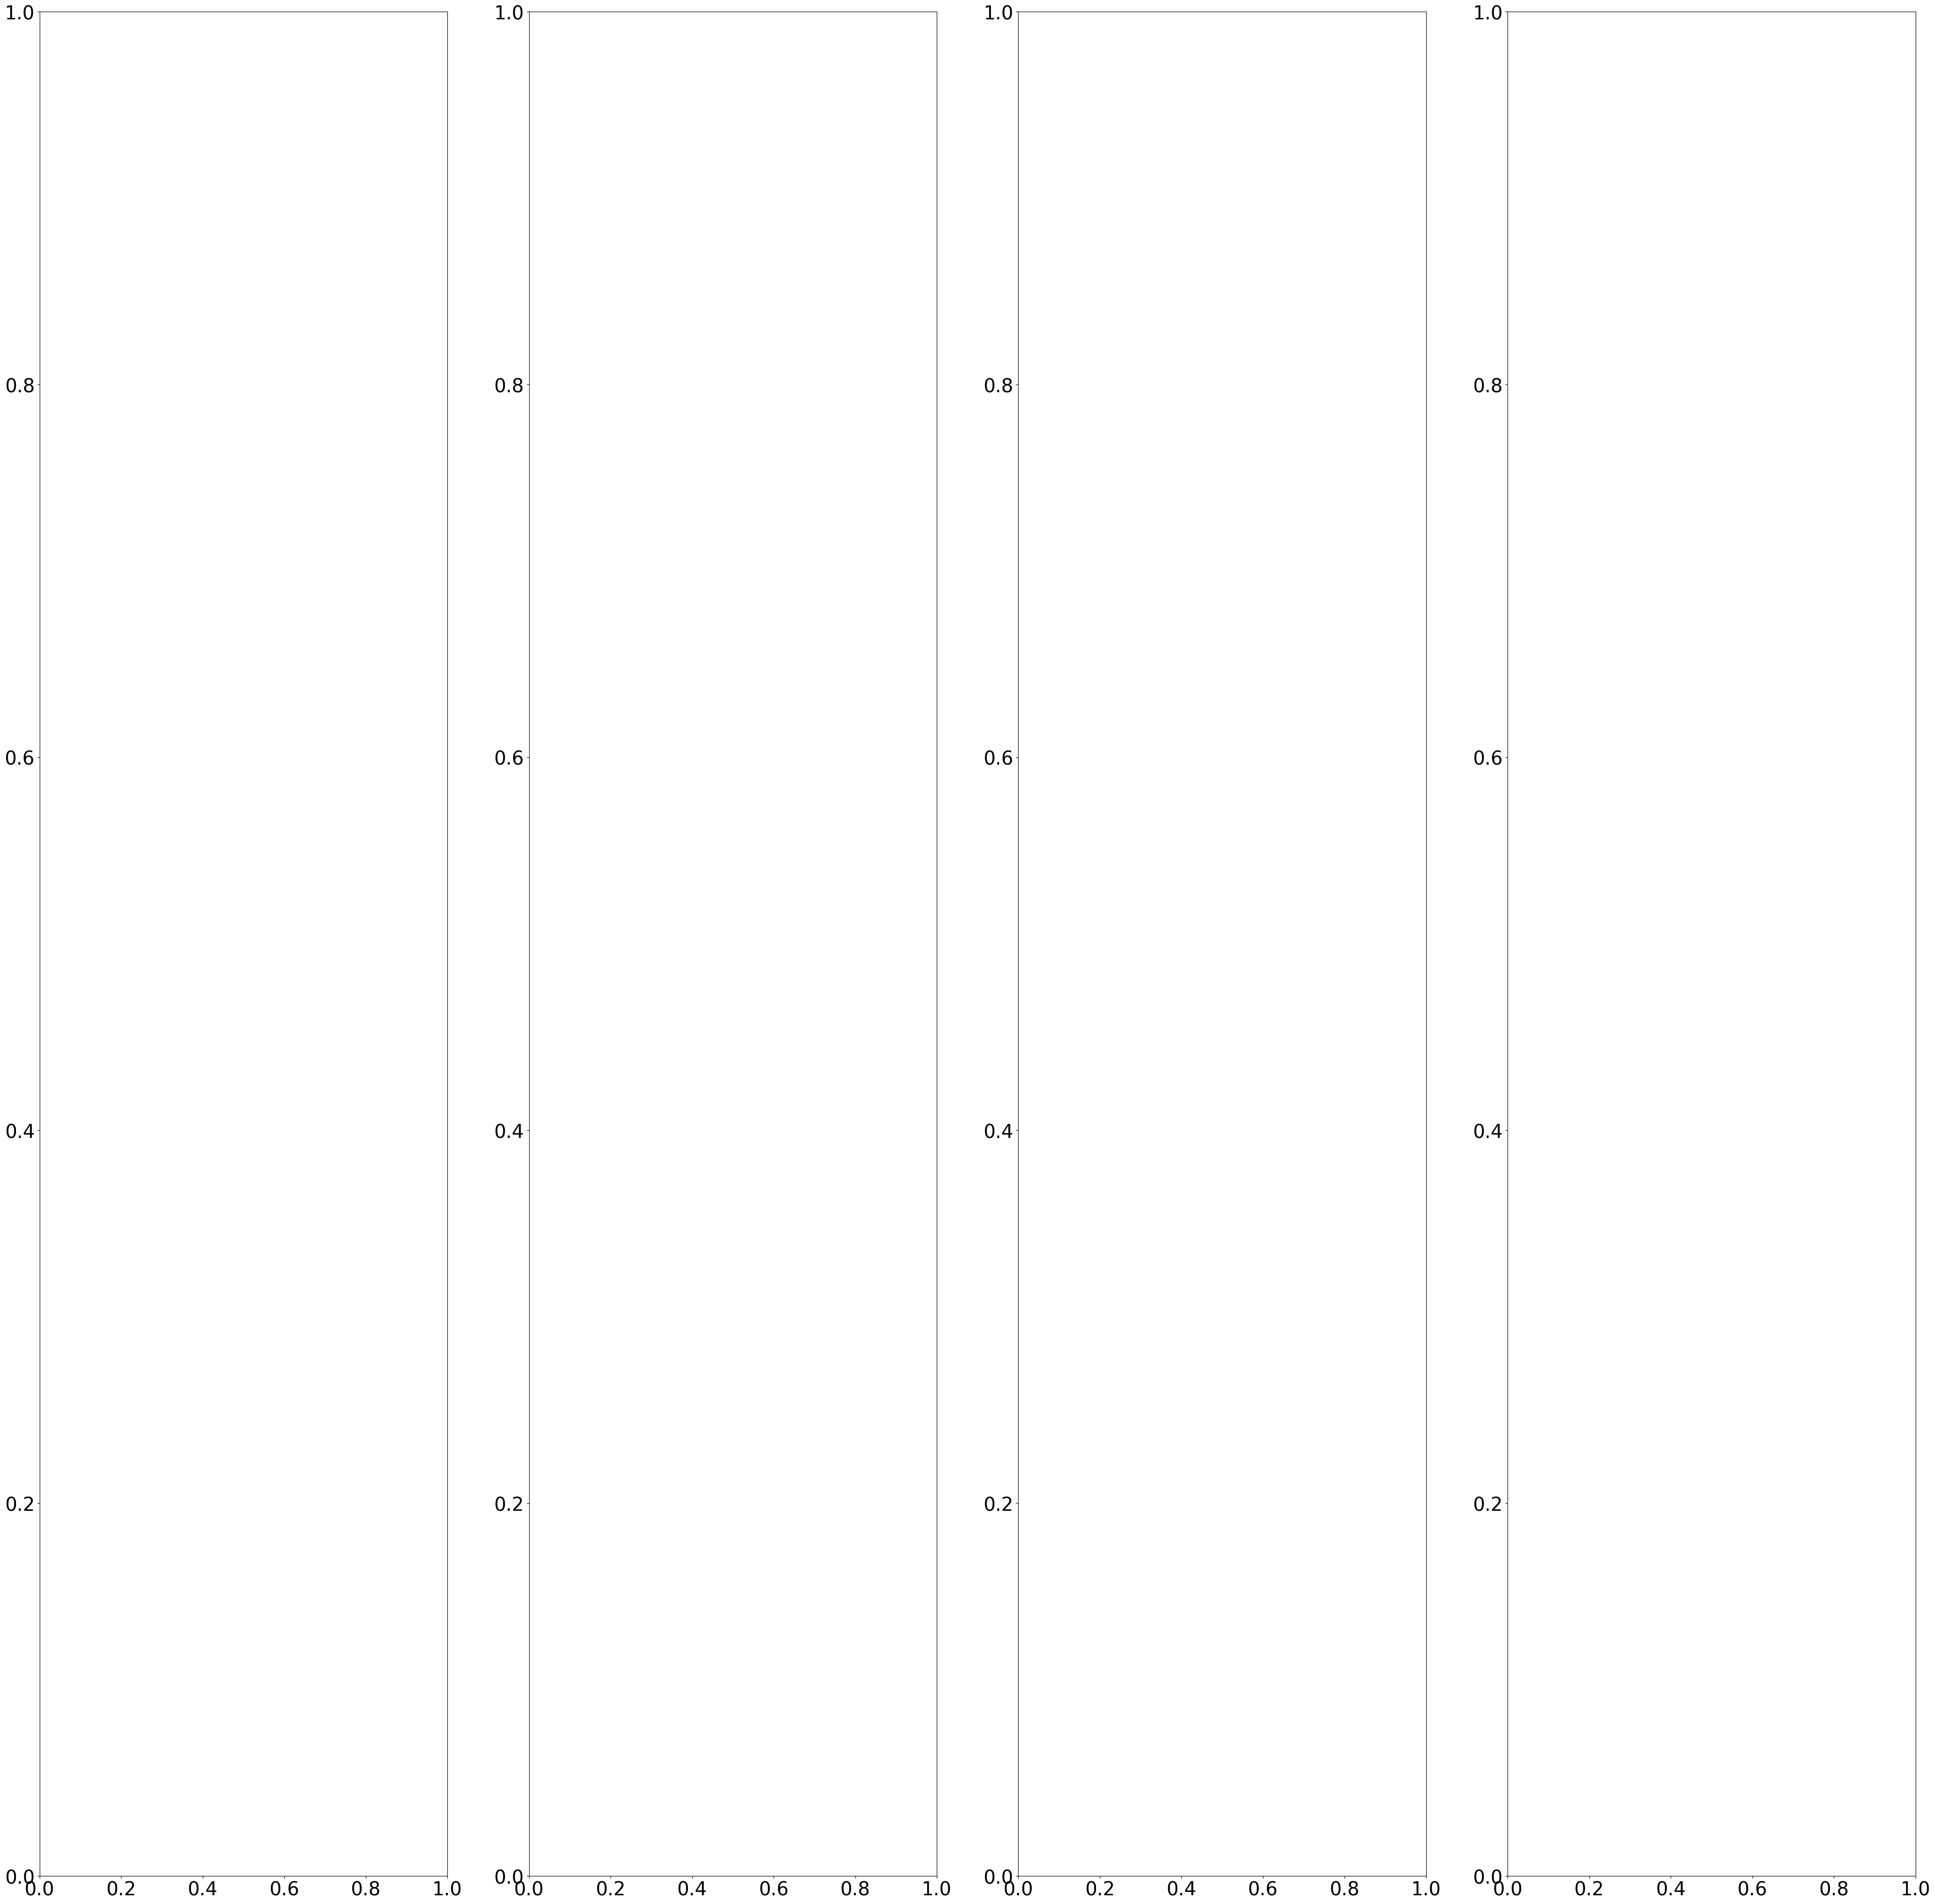

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set font size for various elements in the plot
plt.rcParams['font.size'] = 28
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['legend.fontsize'] = 28

rows, cols = list(set(key[0] for key in scatters.keys())), list(set(key[1] for key in scatters.keys()))
nrows=len(rows)
ncols=len(cols)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(50, 50))

tracking_error = {}
apy ={}
metrics = ['25%', '50%', '75%']

# Iterate through the dictionary and plot each density plot in the correct position
for key, df in scatters.items():
    row = rows.index(key[0])
    col = cols.index(key[1])
    title = f'halflife: {key[0]}, horizon: {key[1]}'
    sns.kdeplot(data=df, 
                x='pred_apy', 
                y='tracking_error', 
                ax=axs[row, col],
                clip=(-1000,1500),
#                hue='datetime',
                legend=False).set(title=title)
    tracking_error[key] = df["tracking_error"].describe()[metrics]
    apy[key] = df["apy"].describe()[metrics]

plt.show()

# tracking error stats

In [ ]:
cm = sns.light_palette("xkcd:copper", as_cmap=True)
stats = pd.concat({'tracking_error': pd.DataFrame(tracking_error), 'apy': pd.DataFrame(apy)}, axis=0)
stats = stats.astype(int)
stats.columns.names=['halflife', 'horizon']
stats.style.background_gradient(cmap=cm, axis=1)

## scatter version

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

rows, cols = list(set(key[0] for key in scatters.keys())), list(set(key[1] for key in scatters.keys()))
nrows=len(rows)
ncols=len(cols)

fig = make_subplots(
    rows=nrows,
    cols=ncols
)

# Iterate through the dictionary and plot each density plot in the correct position
for i, (key, df) in enumerate(scatters.items()):
    row = (i // ncols)+1
    col = (i % ncols)+1
    sns.kdeplot(data=df, x='pred_apy', y='tracking_error', ax=axs[row, col], hue='pool')
    ax = go.Scatter(x=df['pred_apy'], 
                    y=df['tracking_error'],
                    mode='markers',
                    marker=dict(color=df['datetime'].apply(lambda t: pd.to_datetime(t).timestamp())),
                    hovertext=df['datetime'],
                    text=f'halflife: {key[0]}, horizon: {key[1]}')
    fig.add_trace(ax, row=row, col=col)
    
fig.update_layout(height=2000)
fig.show()

# backtests

In [73]:
from datetime import datetime
import os
from itertools import chain
import yaml

df = pd.read_csv('~/Downloads/a.csv', index_col=0, header=[0,1,2], parse_dates=True)

In [96]:
run_name = df.columns.get_level_values(0)[2]
weights = df.xs('weights', level=1, axis=1).xs(run_name, level=0, axis=1)
weights.max().sort_values()/float(run_name.split('_')[-1])*100
weights.drop(columns=['total'], inplace=True)
config = {'chains': list(set(x.split('_')[0] for x in weights.columns)),
         'protocols': list(set(x.split('_')[1] for x in weights.columns)),
         'underlyings': [x for x in set(chain(*[set(map(str.lower,x.split('_')[2].split('-'))) for x in weights.columns]))]
         }
with open('../config/whitelist_gen.yaml', 'w') as fp:
    fp.write(yaml.dump(config))

In [93]:
os.getcwd()

'/home/user/singularity/yieldoptimizer/contango_research'

In [44]:
run_name = df.columns.get_level_values(0)[0]
pool_name = 'Ethereum_morpho-aave_USDC'
apy = df.xs('apy', level=1, axis=1).xs(run_name, level=0, axis=1)
start_date = datetime(2023, 12, 11)
end_date = datetime(2024, 3, 9)
apy[start_date:end_date].mean()*100

/tmp/ipykernel_1405604/496250795.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  apy[start_date:end_date].mean()*100


Base_beefy_DOLA-USDC_Aerodrome                           100.053690
Base_beefy_DOLA-USDBC_Aerodrome                           99.295387
Base_extra-finance_DOLA-USDC_Leveraged Yield Farming     107.515113
Arbitrum_solv-funds_USDT_MUX USDT - A                     24.096108
Base_extra-finance_DOLA-USDBC_Leveraged Yield Farming    107.695179
Ethereum_iron-bank_USDT                                   53.477485
Arbitrum_ramses-v2_USDC-USDT_0.005%                        2.974506
Ethereum_pancakeswap-amm-v3_DAI-USDC_0.01%                 1.623140
total                                                     84.459913
dtype: float64